# **Taller 6: agrupamiento usando K-means.**

**Curso: 09481 - Inteligencia Artificial.**

**Universidad Icesi.**

**Profesor: Breyner Posso.**

**Estudiante: Daniela Olarte.**

En este taller vamos a aplicar el algoritmo de agrupación k-means en dos problemas.

# Parte 1.

# 0. Importar Librerías

In [8]:
#Librerías de interés.
import os

os.environ["OMP_NUM_THREADS"] = "1"

import pandas as pd                #Importamos la librería pandas. Nos va a servir para leer y manipular conjuntos de datos tabulares.
import matplotlib.pyplot as plt    #Importamos pyplot de librería matplotlib. Lo vamos a utilizar para graficar.
import seaborn as sns              #Importamos la librería Seaborn. La vamos a utilizar para graficar.
import numpy as np                 #Importamos la librería numpy para manipular arreglos. 
#from google.colab import files     #Esta librería nos sirve para cargar archivos desde el disco duro.

from sklearn.model_selection import train_test_split #Útil para dividir los conjuntos de datos. 
from sklearn.preprocessing import MinMaxScaler       #Útil para escalar los atributos de entrada.

from copy import deepcopy                            #Permite hacer copias profundas. 

from sklearn.cluster import KMeans                   #Clase que implementa k-means.
from sklearn.metrics import silhouette_samples       #Útil para calcular el valor de la silueta de una observación. 
from sklearn.metrics import silhouette_score         #Útil para calcular el valor de la silueta de todas las observaciones.
from sklearn.metrics import calinski_harabasz_score  #Útil para calcular el valor del índice Calinski Harabasz (CH).
from sklearn.metrics import confusion_matrix         #Permite extraer la matriz de confusión.

#!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer #Permite obtener la gráfica de las siluetas de cada grupo. 

# 1. Cargar Datos

In [11]:
#Primero vamos a descargar el archivo "iris.csv" en nuestra máquina local desde Moodle o desde esta ruta: https://www.kaggle.com/uciml/iris

#Ahora cargamos en Google Colab el archivo que tiene el conjunto de datos "iris.csv"
#files.upload()  #Nota: si este comando falla, revise que su navegador permite el almacenamiento de cookies. 


In [12]:
# Vamos a leer el conjunto de datos en un dataframe de pandas. 
#df = pd.read_csv('/content/iris.csv')
df = pd.read_csv('iris.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


# 2. Análisis Exploratorio de los Datos.

In [14]:
df.shape

(150, 6)

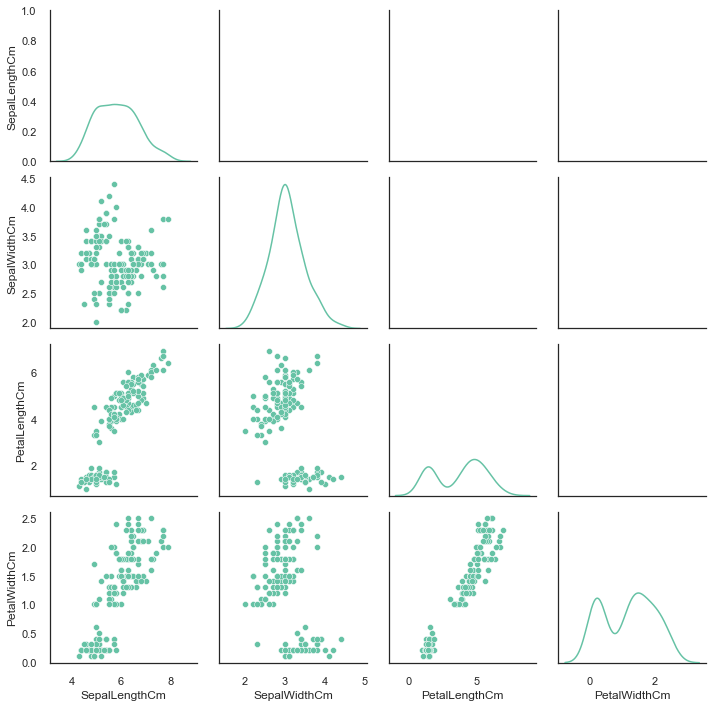

In [15]:
#Como no tenemos datos nulos, lo único que necesitamos hacer es cambiar el dtype de la columna 'Species' de object a category.
df['Species'] = df['Species'].astype('category')

#Categorías del conjunto de datos.
lista_de_especies = df['Species'].unique().to_list()

sns.set(style='white')  #Esto fija el estilo del fondo. Algunas opciones son: 'dark', 'white'
sns.set_palette('Set2') #Para otras opciones de paletas de colores, visite: https://seaborn.pydata.org/tutorial/color_palettes.html
g = sns.PairGrid(data=df.iloc[:,1:],diag_sharey=True)  #Note que no graficamos la columna 0 correspondiente a Id, 
                                                                     #pues no aporta información. Usamos las categorías de la columna de
                                                                     #'Species' para colorear las gráficas.
g.map_diag(sns.kdeplot)      #Muestra gráficos de densidad 1D en la diagonal de la matriz. 
g.map_lower(sns.scatterplot) #Muestra gráficos de dispersión en la sección inferior izquierda de la matriz.

g.add_legend()               #Agrega la leyenda de las especies.
plt.show()

# 3. Modelo y 4. Evaluación

#### Se van a particionar los datos en un conjunto de entrenamiento y uno de prueba. El de entrenamiento se va a utilizar para construir el modelo de Kmeans y hacer agrupamiento (clustering) y el de prueba para probar a qué grupo o categoría asocia estas nuevas observaciones.

In [16]:
# La categoría de cada observación es:
nombre_de_la_variable_de_salida='Species' 
df_y = deepcopy(df[nombre_de_la_variable_de_salida])

#Nombre de los posibles atributos de entrada:
# 'SepalLengthCm'
# 'SepalWidthCm'
# 'PetalLengthCm'
# 'PetalWidthCm'

#En este primer ejemplo vamos a utilizar 2 variables:
nombre_de_las_variables_de_entrada = ['SepalLengthCm','SepalWidthCm']

#Ahora, obtenemos un dataframe con las variables de entrada que vamos a utilizar.
df_x = deepcopy(df[nombre_de_las_variables_de_entrada])

In [17]:
rango_de_salida_de_las_variables_escaladas = (0,1)  #Tupla con el siguiente formato: (mínimo deseado, máximo deseado).
scaler = MinMaxScaler(feature_range=rango_de_salida_de_las_variables_escaladas)  #Instanciamos el objeto para escalar los datos. 

df_x_norm = deepcopy(df_x)  #Inicializamos este objeto con una copia profunda del las columnas de entrada de interés del dataframe.
df_x_norm[nombre_de_las_variables_de_entrada] = scaler.fit_transform(df_x) #Ajustamos y transformamos los datos.

print('-----------------------------------------------------------------------')
print('Datos de entrada del conjunto de entrenamiento ANTES del escalado')
print('-----------------------------------------------------------------------')
print(df_x.describe(),'\n')

print('-----------------------------------------------------------------------')
print('Datos de entrada del conjunto de entrenamiento DESPUÉS del escalado')
print('-----------------------------------------------------------------------')
print(df_x_norm.describe())

-----------------------------------------------------------------------
Datos de entrada del conjunto de entrenamiento ANTES del escalado
-----------------------------------------------------------------------
       SepalLengthCm  SepalWidthCm
count     150.000000    150.000000
mean        5.843333      3.054000
std         0.828066      0.433594
min         4.300000      2.000000
25%         5.100000      2.800000
50%         5.800000      3.000000
75%         6.400000      3.300000
max         7.900000      4.400000 

-----------------------------------------------------------------------
Datos de entrada del conjunto de entrenamiento DESPUÉS del escalado
-----------------------------------------------------------------------
       SepalLengthCm  SepalWidthCm
count     150.000000    150.000000
mean        0.428704      0.439167
std         0.230018      0.180664
min         0.000000      0.000000
25%         0.222222      0.333333
50%         0.416667      0.416667
75%         0.58

In [18]:
# Vamos a dividir los datos en un conjunto de entrenamiento y un conjunto de pruebas.
mezclar_los_datos       = True #Vamos a mezclar de forma aleatoria los datos antes de particionarlos. 
valor_semilla_aleatoria = 42   #Esto es útil si se quiere garantizar la repetibilidad 
                               #de la partición de datos en ejecuciones sucesivas de su notebook o script.
particion_para_pruebas = 0.2

#Hacemos la partición para obtener el conjunto de pruebas y el "resto" (i.e.: entrenamiento y desarrollo).
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x_norm,                                         #100% de los datos de entrada. 
                                                              df_y,                                         #100% de los datos de salida. 
                                                              test_size=particion_para_pruebas, 
                                                              random_state=valor_semilla_aleatoria, 
                                                              shuffle=mezclar_los_datos)

## Estimar el valor de k más adecuado.

### Opción 1: usando scikit-learn y matplotlib.

1. Método del codo.
2. Método de la silueta.
3. Índice Calinski-Harabasz

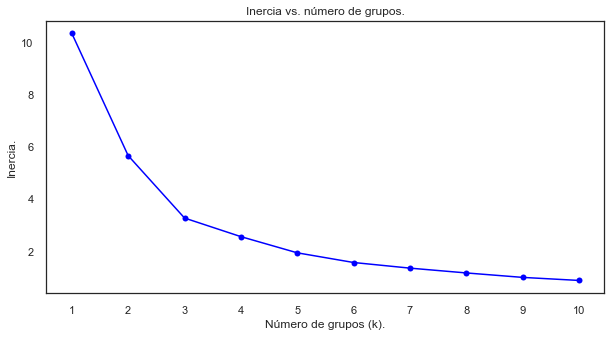

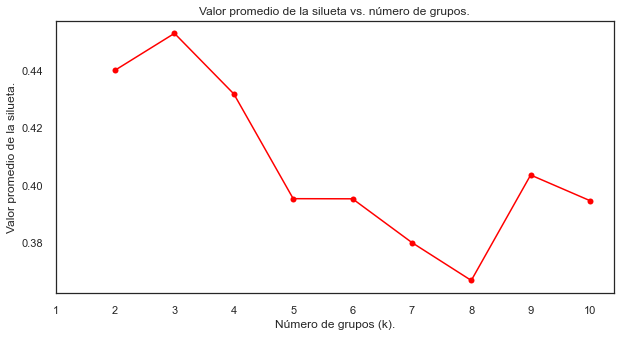

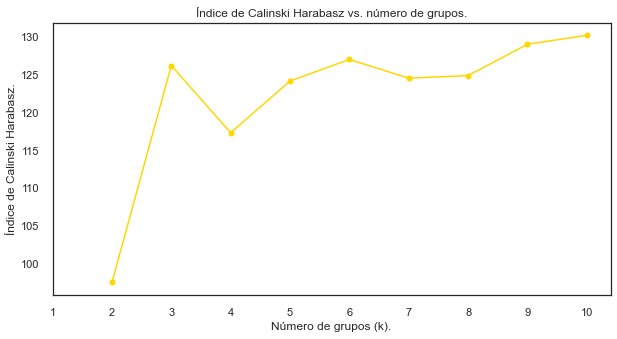

In [19]:
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# HYPERPARÁMETROS DEL MODELO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42          #Semilla aleatoria. Permite obtener los mismos resultados en cada ejecución.

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# CONSTRUCCIÓN Y EVALUACIÓN DE MÚLTIPLES MODELOS VARIANDO K
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------

k_list = list(np.arange(kmin,kmax+1,1))  #Lista con los valores de k que se van a explorar [kmin,kmax].
inertia_list                 = [] #Lista vacía. Va a almacenar los valores de inercia para cada valor de k. 
                                  #La inercia = sumatoria( ( x_i-centroide(x_i) )^2 ). 
                                  #La inercia = sumatoria de los cuadrados de las distancias de las observaciones al centroide más cercano.
silhouette_score_list        = [] #Lista vacía. Va a almacenar los valores de silueta promedio para todas las observaciones para cada valor de k.  
calinski_harabasz_score_list = [] #Lista vacía. Va a almacenar los valores del índice Calinski Harabasz para cada valor de k.  

for k in k_list: #Explore los valores de k en la lista.
  #Se instancia el objeto para utilizar el agrupamiento con k-means.
  #Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
  #Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
  #Si usted requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
  model1 = KMeans(n_clusters=k,        #Se define el número de grupos.
                  init=init,           #Se define el método de inicialización. 
                  n_init=n_init,       #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia. 
                  max_iter=max_iter,   #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state=random_seed)

  #Se hace el ajuste (i.e.: encontramos los centroides).
  model1.fit(df_x_train)

  #Agregamos a la lista el valor de inercia que se obtiene para el número actual de grupos.
  inertia_list.append(model1.inertia_)

  if k==1: #En caso que se esté evaluando el caso cuando el número de grupos es 1...
    silhouette_score_list.append(np.nan)         #Esto sirve como recordatorio que no se puede calcular este valor.
    calinski_harabasz_score_list.append(np.nan)  #Esto sirve como recordatorio que no se puede calcular este índice.
  else:
    #Agregamos a la lista el valor de la silueta promedio para todas las observaciones.
    silhouette_score_list.append(silhouette_score(df_x_train.values, model1.labels_))
    calinski_harabasz_score_list.append(calinski_harabasz_score(df_x_train.values, model1.labels_))  #model1.labels_ es un arreglo numpy de orden 1 (i.e. no es vector fila, no es vector columna...)

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# 1. MÉTODO DEL CODO
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Ahora generamos la gráfica requerida para aplicar el método del codo.
plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
plt.plot(k_list, inertia_list,color='blue',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Inercia.')
plt.title('Inercia vs. número de grupos.')
plt.show()

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# 2. MÉTODO DE LA SILUETA
#https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Revisemos los valores promedio de la silueta para todas las observaciones como función del número de grupos k.
plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
plt.plot(k_list, silhouette_score_list,color='red',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Valor promedio de la silueta.')
plt.title('Valor promedio de la silueta vs. número de grupos.')
plt.show()

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# I. ÍNDICE DE KALINSKI-HARABASZ
#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
#Revisemos los valores del índice Calinski Harabasz como función del número de grupos k.
plt.figure(figsize=(10,5))  #tamaño de la figura (ancho, alto).
plt.plot(k_list, calinski_harabasz_score_list,color='gold',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Índice de Calinski Harabasz.')
plt.title('Índice de Calinski Harabasz vs. número de grupos.')
plt.show()


For k clusters = 2 The average silhouette_score is : 0.4401233596118264


/Users/danielaolarte/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


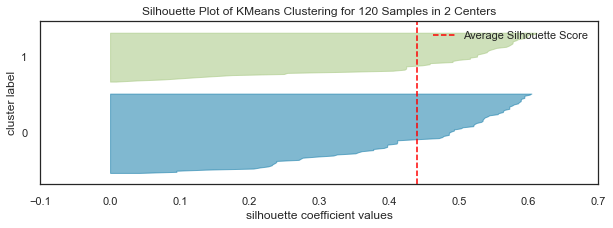

For k clusters = 3 The average silhouette_score is : 0.4529322443318696


/Users/danielaolarte/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


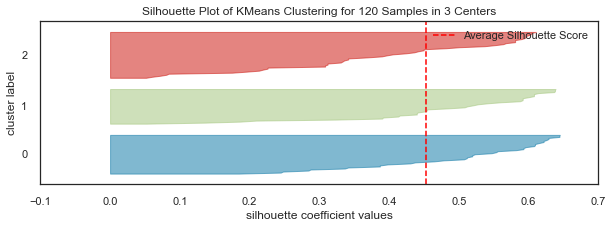

For k clusters = 4 The average silhouette_score is : 0.4318779239380975


/Users/danielaolarte/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


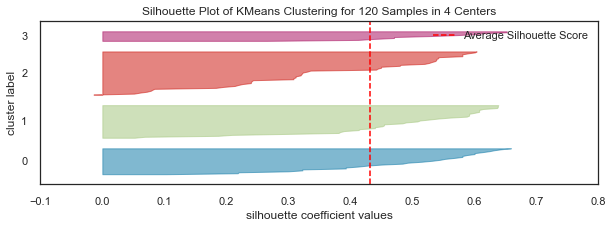

In [20]:
#Revisemos los resultados del método de la silueta para algunos valores
#"tentativos" para k:
silhouette_score_list        = []

for k in [2, 3, 4]:
    model3 = KMeans(n_clusters=k,         #Se define el número de grupos.
                  init=init,            #Se define el método de inicialización. Otra opción es 'random'
                  n_init=n_init,        #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ) 
                  max_iter=max_iter,    #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state=random_seed)
    model3.fit(df_x_train)
    sc = silhouette_score(df_x_train.values, model3.labels_)
    silhouette_score_list.append(sc)
    print(
        "For k clusters =",
        k,
        "The average silhouette_score is :",
        sc,
    )
    plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
    visualizer5 = SilhouetteVisualizer(estimator=model3, colors='yellowbrick')
    visualizer5.fit(df_x_train)
    visualizer5.show() 

#### Pregunta 3.1

¿Cuál considera usted que es el mejor valor para k a partir de las gráficas?

#### Respuesta Pregunta 3.1
El mejor K es 3 y se puede evidenciar mediante los graficos de silueta y Calinski-Harabasz.

### Opción 2: usando algunas funcionalidades de la librería yellowbrick, que a su vez llama a scikit-learn y a matplotlib. https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

1. Método del codo.
2. Método de la silueta.
3. Índice Calinski-Harabasz

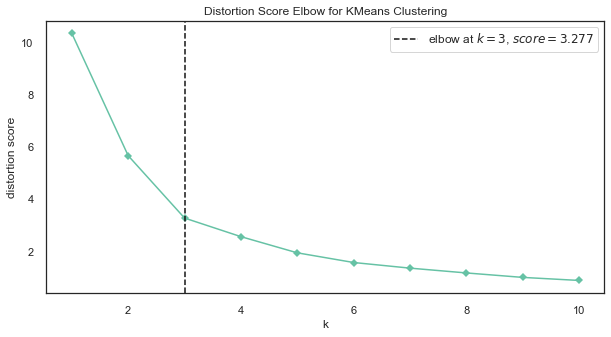

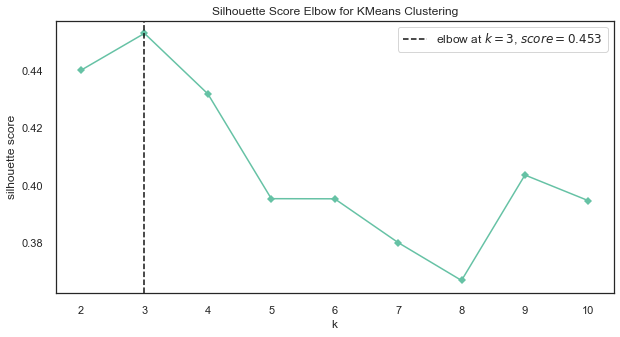

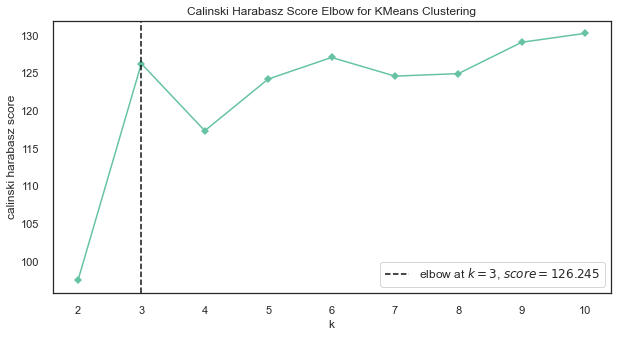

In [21]:
model2 = KMeans(init=init,              #Se define el método de inicialización. 
               n_init=n_init,           #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ). 
               max_iter=max_iter,       #Número MÁXIMO de iteraciones para una sola ejecución.
               random_state=random_seed)

for metric in ["distortion", "silhouette", "calinski_harabasz"]:  #Itere sobre las métricas que soporta KElbowVisualizer.
  
  #Este condicional permite adaptar el flujo pues dos de las métricas requieren al menos 2 grupos para que se puedan calcular.
  if metric=="silhouette" or metric=="calinski_harabasz":  
    kmin_ = max(2,kmin)
  else:
    kmin_ = kmin
  
  plt.figure(figsize=(10,5))   #Tamaño de la figura (ancho, alto).
  visualizer2 = KElbowVisualizer(estimator=model2, 
                                  k=(kmin_,kmax+1),     #Permite explorar valores de k entre [kmin_,kmax].
                                  metric=metric,        #Opciones:  "distortion", "silhouette", "calinski_harabasz"
                                  timings=False,          
                                  locate_elbow=True)   #Si esta opción se activa, ubica el codo con una línea punteada.
  visualizer2.fit(df_x_train)   #Ajusta los datos al visualizador.
  visualizer2.show()

### Se entrena el modelo definitivo.

In [22]:
#-------------------------------------------------------------------------------
#K-means
#-------------------------------------------------------------------------------
k = 3  #Número de grupos que se escogió después del análisis previo.

#Ahora se instancia el objeto para utilizar el agrupamiento con k-means.
#Para ver todas los opciones del constructor, consulte: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
#Nota: el algoritmo de k-means disponible en scikit-learn funciona únicamente con la distancia euclidiana.
#Si requiere aplicar k-means con otras métricas de distancia, puede consultar la librería PyClustering: https://github.com/annoviko/pyclustering
kmeans = KMeans(n_clusters   = k,            #Se define el número de grupos.
                init         = init,         #Se define el método de inicialización. Otra opción es 'random'
                n_init       = n_init,       #Número de inicializaciones aleatorias. 
                max_iter     = max_iter,     #Número MÁXIMO de iteraciones para una sola ejecución.
                random_state = random_seed)

#Hagamos el ajuste (i.e.: encontremos los centroides).
kmeans.fit(df_x_train)

#Revisemos los centroides de cada grupo.
centroides = kmeans.cluster_centers_
print('Centroides:', centroides)


Centroides: [[0.1951567  0.61217949]
 [0.69603175 0.46547619]
 [0.39855072 0.27626812]]


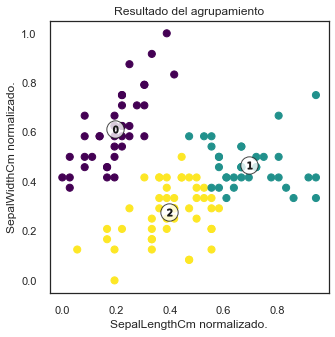

In [23]:
#Grafiquemos las observaciones y los centroides de cada grupo.
plt.figure(figsize=(5,5))
plt.scatter(df_x_train.iloc[:,0],   df_x_train.iloc[:,1], c=kmeans.labels_.reshape((-1,1)), s=50,  cmap='viridis')  
plt.scatter(centroides[:, 0], centroides[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       
plt.xlabel(df_x_train.columns[0]+' normalizado.')
plt.ylabel(df_x_train.columns[1]+' normalizado.')

#Esto permite identificar cada centroide con su índice asociado. 
for i, c in enumerate(centroides):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

### Se prueba el agrupamiento comparando los grupos creados con los tipos de flores (conjunto usado para entrenar)

In [24]:
#Revisemos los índices de los grupos a los que se asignó cada observación.
print('Índices del grupo al que se asoció cada observación:',kmeans.labels_,'\n')
print('Dimensiones', kmeans.labels_.shape,'\n')  #Arreglo de rango 1.
print('Tipo de dato', type(kmeans.labels_))

Índices del grupo al que se asoció cada observación: [0 0 1 0 0 2 1 0 0 0 2 1 1 0 0 2 2 1 1 1 2 1 2 0 1 2 0 0 0 2 2 0 0 0 2 0 2
 1 0 2 2 0 2 2 2 2 1 2 0 2 2 0 0 2 1 0 2 0 0 2 2 1 2 2 1 2 0 0 2 1 0 0 0 2
 1 0 1 1 0 2 1 2 1 1 0 1 2 1 2 2 2 2 1 2 0 2 1 1 0 2 1 1 0 1 0 1 1 1 2 1 2
 1 2 2 0 2 2 0 2 1] 

Dimensiones (120,) 

Tipo de dato <class 'numpy.ndarray'>


In [25]:
#Revisemos las CATEGORÍAS REALES y sus CÓDIGOS.
print('Nombre de la categoría real para cada observación:',df_y_train.values,'\n')
print('Código numérico de la categoría real para cada observación: ',df_y_train.cat.codes.values,'\n')  #Revisemos los códigos correspondientes

Nombre de la categoría real para cada observación: ['Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', ..., 'Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
Length: 120
Categories (3, object): ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'] 

Código numérico de la categoría real para cada observación:  [0 0 1 0 0 2 1 0 0 0 2 1 1 0 0 1 2 2 1 2 1 2 1 0 2 1 0 0 0 1 2 0 0 0 1 0 1
 2 0 1 2 0 2 2 1 1 2 1 0 1 2 0 0 1 1 0 2 0 0 1 1 2 1 2 2 1 0 0 2 2 0 0 0 1
 2 0 2 2 0 1 1 2 1 2 0 2 1 2 1 1 1 0 1 1 0 1 2 2 0 1 2 2 0 2 0 1 2 2 1 2 1
 1 2 2 0 1 2 0 1 2] 



In [26]:
df_y_train_mod = df_y_train.replace(['Iris-setosa','Iris-versicolor','Iris-virginica'],[0,1,2])

In [27]:
df_y_train_mod

22     0
15     0
65     1
11     0
42     0
      ..
71     1
106    2
14     0
92     1
102    2
Name: Species, Length: 120, dtype: category
Categories (3, int64): [0, 1, 2]

In [28]:
#Usemos una "matriz de confusión" para evaluar la correspondencia entre las categorías reales, y los grupos que encontró k-means.  

#En esta matriz de confusión:
#Las filas representan los códigos asociados a la categoría real.
#Las columnas representan los índices de los grupos que encontró k-means.
cm_train = confusion_matrix(df_y_train_mod,kmeans.labels_)
print(cm_train)

[[39  0  1]
 [ 0 11 30]
 [ 0 24 15]]


### El agrupamiento sirve para clasificar  nuevas muestras, es decir, asignar una observación nueva a uno de los grupos.

In [29]:
y_pred_test = kmeans.predict(df_x_test)
print(y_pred_test)

[2 0 1 2 1 0 2 1 2 2 1 0 0 0 0 1 1 2 2 1 0 2 0 1 1 1 1 1 0 0]


In [30]:
df_y_test_mod = df_y_test.replace(['Iris-setosa','Iris-versicolor','Iris-virginica'],[0,1,2])

In [31]:
cm_test = confusion_matrix(df_y_test_mod,y_pred_test)
print(cm_test)

[[10  0  0]
 [ 0  2  7]
 [ 0 10  1]]


#### Pregunta 3.2

Realice el agrupamiento con tres atributos (los dos que se usaron y uno nuevo). Seleccione el valor de k y luego pruebe si el nuevo agrupamiento mejora la clasificación de las observaciones nuevas.

In [32]:
# Respuesta Pregunta 3.2
output ='Species' 
df_y = deepcopy(df[output])

input = ['SepalLengthCm','SepalWidthCm', 'PetalLengthCm']

df_x = deepcopy(df[input])

In [33]:
range = (0, 1)
scaler = MinMaxScaler(feature_range=range)

df_x = scaler.fit_transform(df_x)

In [34]:
mix = True
seed = 42

partition = 0.2

df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=partition, random_state=seed, shuffle=mix)

##### Hiperparámetros

In [35]:
kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42

##### Modelo

In [36]:
k_list = list(np.arange(kmin,kmax+1,1)) 

inertia_list = []
silhouette_list = []
ch_list = []

for k in k_list: 
    model = KMeans (n_clusters = k, 
                    init = init, 
                    n_init = n_init, 
                    max_iter = max_iter, 
                    random_state = random_seed)

    model.fit(df_x_train)
    inertia_list.append(model.inertia_)
    if k==1:
        silhouette_list.append(np.nan)
        ch_list.append(np.nan)
    else:
        silhouette_list.append(silhouette_score(df_x_train, model.labels_))
        ch_list.append(calinski_harabasz_score(df_x_train, model.labels_))

##### Método del codo

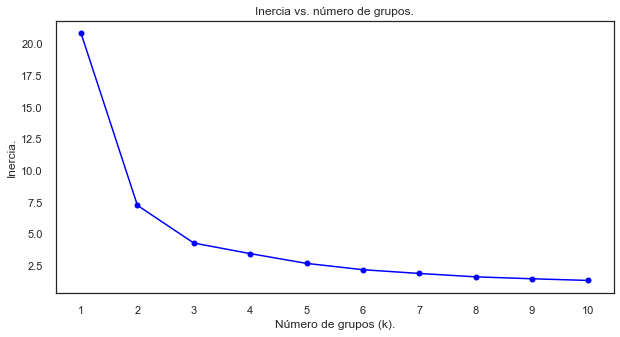

In [37]:
plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
plt.plot(k_list, inertia_list,color='blue',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Inercia.')
plt.title('Inercia vs. número de grupos.')
plt.show()

##### Método de la silueta

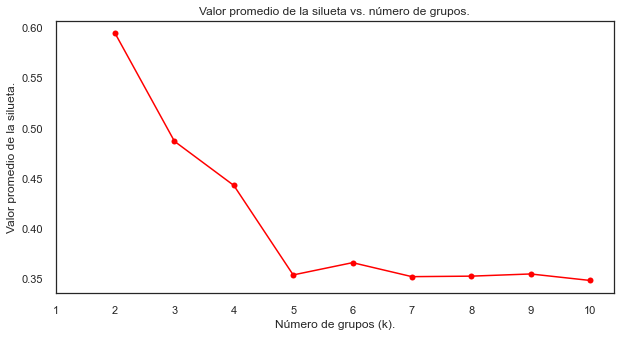

In [38]:
plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
plt.plot(k_list, silhouette_list,color='red',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Valor promedio de la silueta.')
plt.title('Valor promedio de la silueta vs. número de grupos.')
plt.show()

##### Índice Calinski-Harabasz

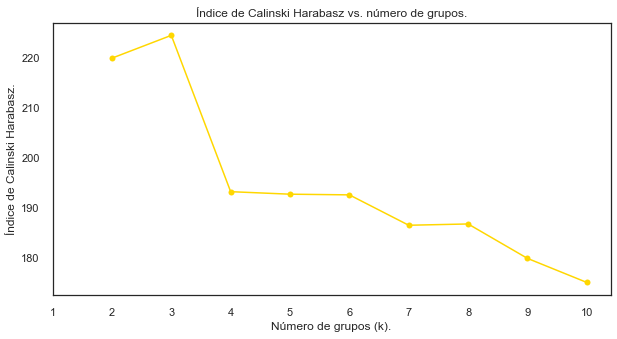

In [39]:
plt.figure(figsize=(10,5))  #tamaño de la figura (ancho, alto).
plt.plot(k_list, ch_list,color='gold',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Índice de Calinski Harabasz.')
plt.title('Índice de Calinski Harabasz vs. número de grupos.')
plt.show()

For k clusters = 2 The average silhouette_score is : 0.5945867374670125


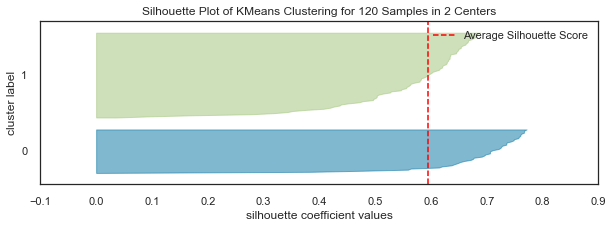

For k clusters = 3 The average silhouette_score is : 0.4872116110159354


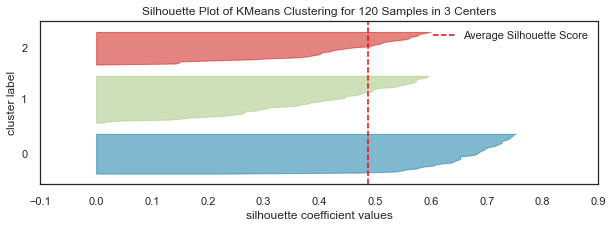

For k clusters = 4 The average silhouette_score is : 0.44330785935136613


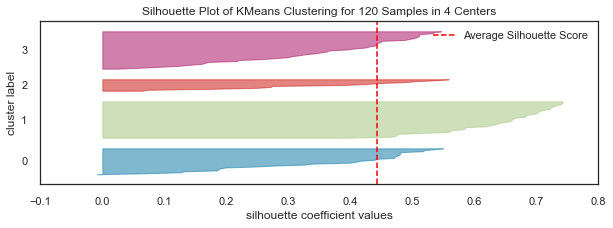

In [40]:
silhouette_score_list        = []

for k in [2, 3, 4]:
    model3 = KMeans(n_clusters=k,         #Se define el número de grupos.
                  init=init,            #Se define el método de inicialización. Otra opción es 'random'
                  n_init=n_init,        #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ) 
                  max_iter=max_iter,    #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state=random_seed)
    model3.fit(df_x_train)
    sc = silhouette_score(df_x_train, model3.labels_)
    silhouette_score_list.append(sc)
    print(
        "For k clusters =",
        k,
        "The average silhouette_score is :",
        sc,
    )
    plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
    visualizer5 = SilhouetteVisualizer(estimator=model3, colors='yellowbrick')
    visualizer5.fit(df_x_train)
    visualizer5.show() 

##### Elección del mejor k
El mejor K es 2 y se puede evidenciar en el grafico de silueta y Calinski-Harabasz al tener un alto indice

#### Pregunta 3.3

Realice el agrupamiento con los cuatro atributos. Seleccione el valor de k y luego pruebe si el nuevo agrupamiento mejora la clasificación de las observaciones nuevas.

In [41]:
# Respuesta Pregunta 3.3
output_2 ='Species' 
df_y_2 = deepcopy(df[output_2])

input_2 = ['SepalLengthCm','SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

df_x_2 = deepcopy(df[input_2])

In [42]:
range = (0, 1)
scaler = MinMaxScaler(feature_range=range)

df_x_2 = scaler.fit_transform(df_x_2)

In [43]:
mix = True
seed = 42

partition = 0.2

df_x_train2, df_x_test2, df_y_train2, df_y_test2 = train_test_split(df_x_2, df_y_2, test_size=partition, random_state=seed, shuffle=mix)

##### Hiperparámetros

In [44]:
kmin              = 1           #Límite inferior para explorar el número de grupos.
kmax              = 10          #Límite superior para explorar el número de grupos.
init              ='k-means++'  #Se define el método de inicialización. Otra opción válida es 'random'.
n_init            = 10          #Número de inicializaciones aleatorias. Al final scikit learn escoge aquel con la menor inercia 
                                #(i.e.: suma de cuadrados de distancias de cada punto a su centroide respectivo dentro de cada grupo, para todos los puntos). 
                                #https://scikit-learn.org/stable/modules/clustering.html
max_iter          = 300         #Número MÁXIMO de iteraciones para una sola ejecución.
random_seed       = 42

##### Modelo

In [45]:
k_list = list(np.arange(kmin,kmax+1,1)) 

inertia_list = []
silhouette_list = []
ch_list = []

for k in k_list: 
    model_4_att = KMeans (n_clusters = k, 
                    init = init, 
                    n_init = n_init, 
                    max_iter = max_iter, 
                    random_state = random_seed)

    model_4_att.fit(df_x_train2)
    inertia_list.append(model_4_att.inertia_)
    if k==1:
        silhouette_list.append(np.nan)
        ch_list.append(np.nan)
    else:
        silhouette_list.append(silhouette_score(df_x_train2, model_4_att.labels_))
        ch_list.append(calinski_harabasz_score(df_x_train2, model_4_att.labels_))

##### Método del codo

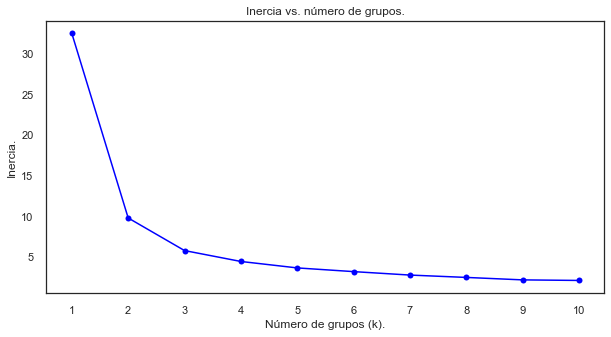

In [46]:
plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
plt.plot(k_list, inertia_list,color='blue',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Inercia.')
plt.title('Inercia vs. número de grupos.')
plt.show()

##### Método de la silueta

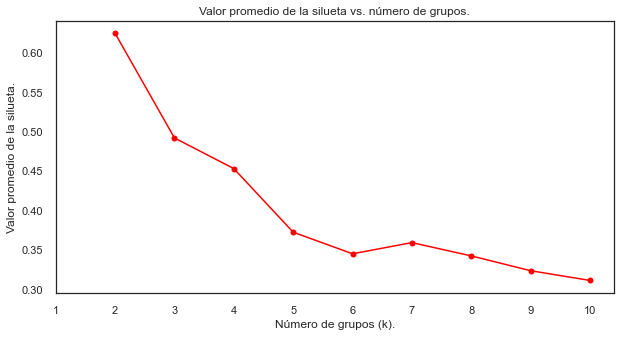

In [47]:
plt.figure(figsize=(10,5))  #Tamaño de la figura (ancho, alto).
plt.plot(k_list, silhouette_list,color='red',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Valor promedio de la silueta.')
plt.title('Valor promedio de la silueta vs. número de grupos.')
plt.show()

##### Índice Calinski-Harabasz

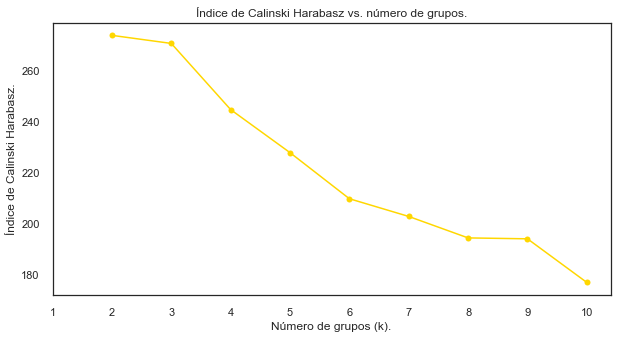

In [48]:
plt.figure(figsize=(10,5))  #tamaño de la figura (ancho, alto).
plt.plot(k_list, ch_list,color='gold',marker='o')
plt.xlabel('Número de grupos (k).')
plt.xticks(ticks=k_list)
plt.ylabel('Índice de Calinski Harabasz.')
plt.title('Índice de Calinski Harabasz vs. número de grupos.')
plt.show()

For k clusters = 2 The average silhouette_score is : 0.6249575552663172


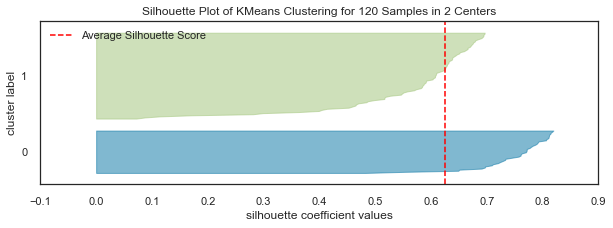

For k clusters = 3 The average silhouette_score is : 0.4921247335850293


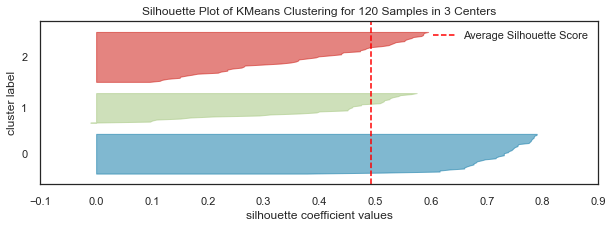

For k clusters = 4 The average silhouette_score is : 0.45323302333801785


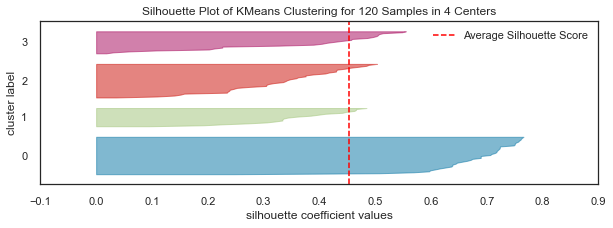

In [49]:
silhouette_score_list        = []

for k in [2, 3, 4]:
    model4 = KMeans(n_clusters=k,         #Se define el número de grupos.
                  init=init,            #Se define el método de inicialización. Otra opción es 'random'
                  n_init=n_init,        #Número de inicializaciones aleatorias. Al final se escoge aquel con la menor inercia: sum( (x_i-centroide(x_i))^2 ) 
                  max_iter=max_iter,    #Número MÁXIMO de iteraciones para una sola ejecución.
                  random_state=random_seed)
    model4.fit(df_x_train2)
    sc = silhouette_score(df_x_train2, model4.labels_)
    silhouette_score_list.append(sc)
    print(
        "For k clusters =",
        k,
        "The average silhouette_score is :",
        sc,
    )
    plt.figure(figsize=(10,3))  #Tamaño de la figura (ancho, alto).
    visualizer5 = SilhouetteVisualizer(estimator=model4, colors='yellowbrick')
    visualizer5.fit(df_x_train2)
    visualizer5.show() 

##### Conclusiones

El mejor K es 2 y se puede evidenciar en el grafico de silueta y Calinski-Harabasz donde se refleja un alto indice y es el menor k posible. 

# **EJERCICIOS PROPUESTOS TALLER 6.**

In [57]:
# Vamos a leer el conjunto de datos en un dataframe de pandas. 
df = pd.read_csv('Mall_Customers.csv')

In [74]:
df['Genre'] = df['Genre'].astype('category')

In [75]:
df = df.replace(['Male','Female'],[0,1])

In [91]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## Constantes

### Rango de normalización

In [76]:
range = (0, 1)
scaler = MinMaxScaler(feature_range=range)

### Parámetros para el split

In [77]:
mix = True
seed = 42

partition = 0.2

### Hiperparámetros para el modelo

In [78]:
kmin              = 1           
kmax              = 10          
init              ='k-means++'  
n_init            = 10            
                                
max_iter          = 300         
random_seed       = 42

## Ejercicio 1.

Realice la mejor agrupación de los clientes de acuerdo con el Ingreso Anual y el Spending Score. Pruebe diferentes valores de k, normalice si considera necesario y use las diferentes métricas para comparar el desempeño de las agrupaciones.

¿Cuántos grupos encontró? ¿Qué 'insights' se pueden extraer de esta segmentación de los clientes?

In [79]:
input = ['Annual Income (k$)', 'Spending Score (1-100)']
df_x = deepcopy(df[input])

In [80]:
df_x_norm = deepcopy(df_x) 
df_x_norm[input] = scaler.fit_transform(df_x)

### Modelo

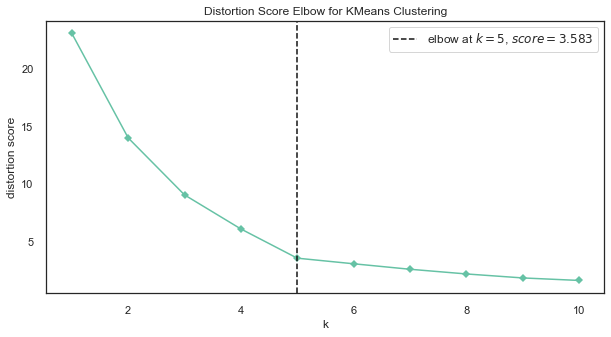

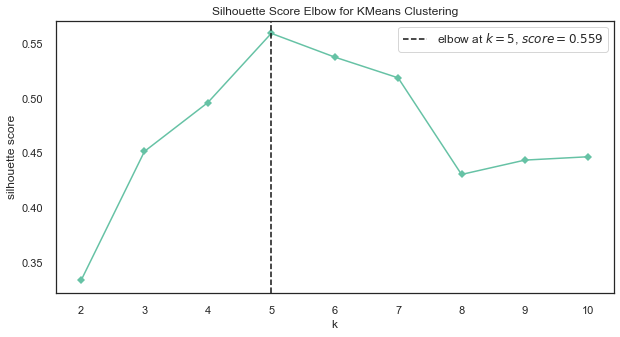

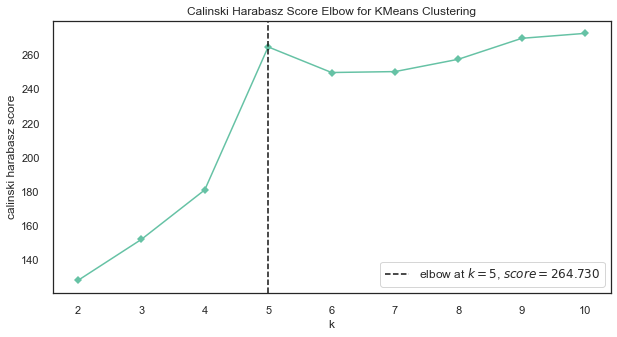

In [81]:
model = KMeans(init=init,
               n_init=n_init, 
               max_iter=max_iter, 
               random_state=random_seed)

for metric in ['distortion', 'silhouette', 'calinski_harabasz']:
    if metric=="silhouette" or metric=="calinski_harabasz":  
        kmin_ = max(2,kmin)
    else:
        kmin_ = kmin

    plt.figure(figsize=(10,5)) 

    visualizer = KElbowVisualizer(estimator=model, 
                                 k=(kmin_, kmax+1), 
                                 metric=metric, 
                                 timings=False,
                                 locate_elbow=True)
    visualizer.fit(df_x_norm)        
    visualizer.show() 

### Entrenamiento

In [92]:
k = 5

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))

Centroides: [[0.33029751 0.49508692]
 [0.6        0.16443149]
 [0.09265859 0.20319432]
 [0.08792846 0.79962894]
 [0.58638083 0.82783883]]
Etiquetas: [0 1 2 3 4]


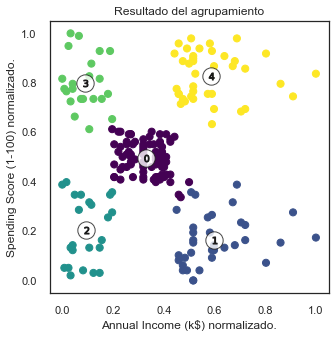

In [93]:
plt.figure(figsize=(5,5))
plt.scatter(df_x_norm.iloc[:,0],   df_x_norm.iloc[:,1], c=labels.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_norm.columns[0]+' normalizado.')
plt.ylabel(df_x_norm.columns[1]+' normalizado.')

for i, c in enumerate(centroids):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

* El resultado son 5 centroides en torno a los cuales se agrupan los puntos y las etiquetas para cada punto que indican a qué cluster pertenece dicho punto
* Las perspectivas que se pueden extraer de esta segmentación es que al evaluar los 5 centroides que se encuentran, el grupo 0 es el que cuenta con datos mejor agrupados en comparación con los otros grupos donde los datos se encuentran a mayor distancia del centroide. 
* De acuerdo con las graficas del codo, silhoutte y calinski se puede evidenciar que k=5 es el mejor valor que se puede presentar para el mismo. 

## Ejercicio 2.


Realice la mejor agrupación de los clientes de acuerdo con la Edad y el Spending Score. Pruebe diferentes valores de k, normalice si considera necesario y use las diferentes métricas para comparar el desempeño de las agrupaciones.

¿Cuántos grupos encontró? ¿Qué 'insights' se pueden extraer de esta segmentación de los clientes?

In [102]:
input = ['Age', 'Spending Score (1-100)']
df_x = deepcopy(df[input])

### Modelo

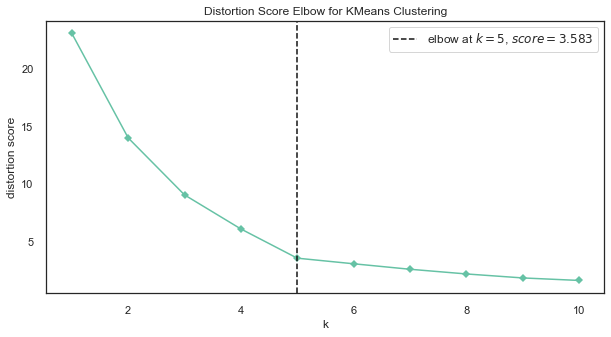

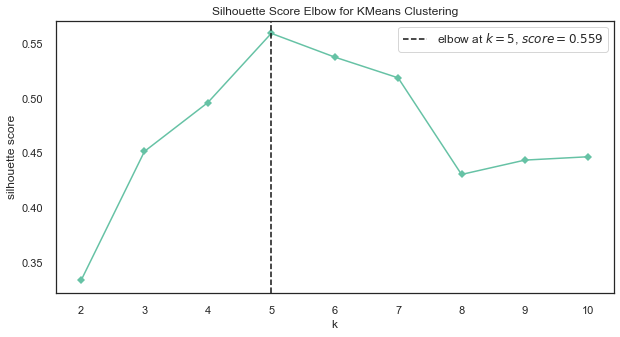

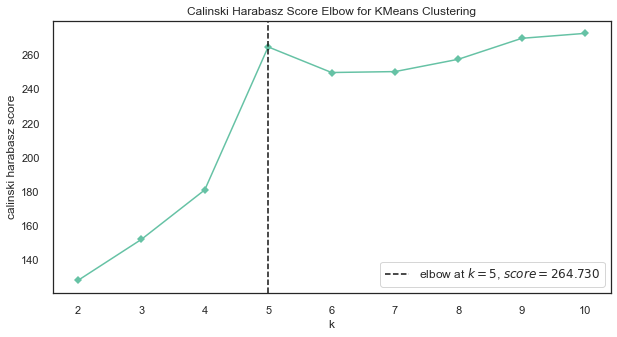

In [103]:
model = KMeans(init=init,
               n_init=n_init, 
               max_iter=max_iter, 
               random_state=random_seed)

for metric in ['distortion', 'silhouette', 'calinski_harabasz']:
    if metric=="silhouette" or metric=="calinski_harabasz":  
        kmin_ = max(2,kmin)
    else:
        kmin_ = kmin

    plt.figure(figsize=(10,5)) 

    visualizer = KElbowVisualizer(estimator=model, 
                                 k=(kmin_, kmax+1), 
                                 metric=metric, 
                                 timings=False,
                                 locate_elbow=True)
    visualizer.fit(df_x_norm)        
    visualizer.show() 

In [104]:
k = 5

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))

Centroides: [[0.33029751 0.49508692]
 [0.6        0.16443149]
 [0.09265859 0.20319432]
 [0.08792846 0.79962894]
 [0.58638083 0.82783883]]
Etiquetas: [0 1 2 3 4]


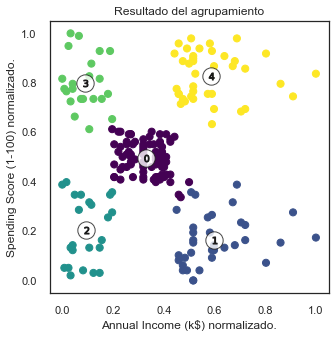

In [105]:
plt.figure(figsize=(5,5))
plt.scatter(df_x_norm.iloc[:,0],   df_x_norm.iloc[:,1], c=labels.reshape((-1,1)), s=50,  cmap='viridis')  #Observaciones.
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', color='white', edgecolor='k', s=300, alpha=0.8)       #Centroides.
plt.xlabel(df_x_norm.columns[0]+' normalizado.')
plt.ylabel(df_x_norm.columns[1]+' normalizado.')

for i, c in enumerate(centroids):
  plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Resultado del agrupamiento')
plt.show()

* El resultado son 5 centroides en torno a los cuales se agrupan los puntos y las etiquetas para cada punto que indican a qué cluster pertenece dicho punto
* Las perspectivas que se pueden extraer de esta segmentación es que al evaluar los 4 centroides que se encuentran, el grupo 2 es el que cuenta con datos mejor agrupados en comparación con el grupo 2. 
* De acuerdo con las graficas del codo, silhoutte y calinski se puede evidenciar que la grafica del codo sugiere que el mejor k es 5 debido a que se sus datos son mas agrupados.

## Ejercicio 3.

Realice la mejor agrupación de los clientes de acuerdo con el Género y el Spending Score. Pruebe diferentes valores de k, normalice si considera necesario y use las diferentes métricas para comparar el desempeño de las agrupaciones.

¿Cuántos grupos encontró? ¿Qué 'insights' se pueden extraer de esta segmentación de los clientes?

In [109]:
input = ['Genre', 'Spending Score (1-100)']
df_x = deepcopy(df[input])

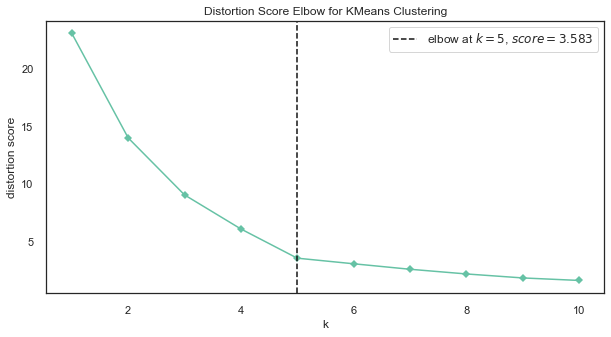

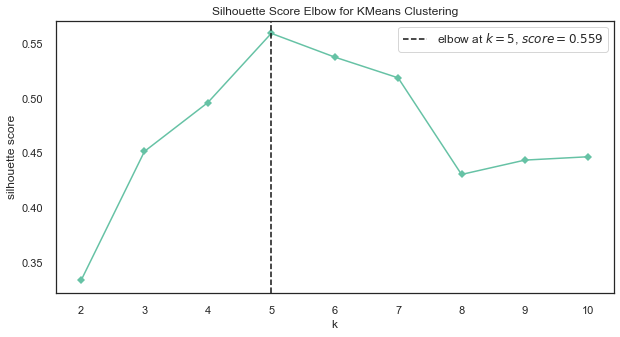

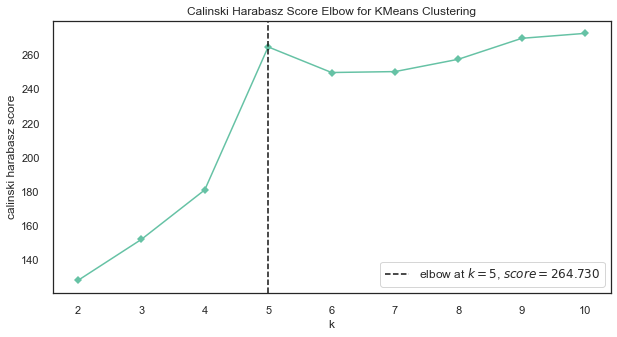

In [110]:
model = KMeans(init=init,
               n_init=n_init, 
               max_iter=max_iter, 
               random_state=random_seed)

for metric in ['distortion', 'silhouette', 'calinski_harabasz']:
    if metric=="silhouette" or metric=="calinski_harabasz":  
        kmin_ = max(2,kmin)
    else:
        kmin_ = kmin

    plt.figure(figsize=(10,5)) 

    visualizer = KElbowVisualizer(estimator=model, 
                                 k=(kmin_, kmax+1), 
                                 metric=metric, 
                                 timings=False,
                                 locate_elbow=True)
    visualizer.fit(df_x_norm)        
    visualizer.show() 

In [108]:
k = 2

kmeans = KMeans(init=init,
                n_clusters=k,
                n_init=n_init,
                max_iter=max_iter,
                random_state=random_seed)

kmeans.fit(df_x_norm)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print('Centroides:', centroids)
print('Etiquetas:', np.unique(labels))

Centroides: [[0.36929553 0.31163817]
 [0.37861485 0.73950929]]
Etiquetas: [0 1]


# **Metodología**

1. Desarrolle de forma individual las preguntas propuestas en el Taller 6.

2. Después de la sesión de Taller 6, suba a Intu el archivo con la solución a las preguntas con nombre en el siguiente formato:

Taller_6_Apellido-Nombre.ipynb

3. Resuelva los Ejercicios Propuestos (en grupos de máximo 2 personas) en un nuevo notebook de Jupyter y suba el archivo a Intu hasta el próximo miércoles 12 de octubre a las 7:00 am (antes del inicio de la clase). Utilice el siguiente formato para el nombre del archivo.

Ejercicios_Taller_6_Apellido-Nombre_Apellido-Nombre.ipynb

4.	Recuerde consignar los nombres de los integrantes dentro del notebook.

5.	Algunos grupos serán llamados al azar durante la clase para realizar la presentación de los resultados de los Ejercicios Propuestos.

6. La nota del Taller 6 se asignará así:

- Preguntas Taller 6 (20%)

- Ejercicios Taller 6 (80%)